# Milestone 2: Image Understanding & Retrieval System

This notebook implements a lightweight image understanding system that can:
1. Classify images into 10 object classes
2. Predict visual attributes (color, material, condition)
3. Retrieve matching images for text queries like "blue plastic jug"

We use two lightweight Vision Transformer variants: **DeiT-Tiny** and **MobileViT**, both fine-tuned on the dataset.


In [34]:
# Install required packages (uncomment if needed)
# !pip install torch torchvision timm transformers sentence-transformers pillow pandas numpy scikit-learn matplotlib seaborn tqdm


In [1]:
print("check")

check


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import json
import warnings
warnings.filterwarnings('ignore')

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

# Force CPU if needed (for lightweight/CPU-only requirement)
# device = torch.device('cpu')
# print("Forced to use CPU")


Using device: cuda
PyTorch version: 2.5.1+cu121


## 1. Data Loading and Exploration


In [37]:
# Load labels.csv
df = pd.read_csv('labels.csv')
print(f"Total samples: {len(df)}")
print(f"\nSplit distribution:")
print(df['split'].value_counts())
print(f"\nClass distribution:")
print(df['class_label'].value_counts())
print(f"\nUnique classes: {len(df['class_label'].unique())}")
print(f"Classes: {sorted(df['class_label'].unique())}")
print(f"\nFirst few rows:")
df.head()


Total samples: 600

Split distribution:
split
train    447
val      100
test      53
Name: count, dtype: int64

Class distribution:
class_label
clothing_cap                      60
clothing_wrist_watch              60
food_storage_plastic_container    60
footwear_sneakers                 60
personal_care_deodorant           60
personal_care_shampoo_bottle      60
personal_care_soap_bar            60
tableware_water_bottle            60
travel_backpack                   60
travel_handbag                    60
Name: count, dtype: int64

Unique classes: 10
Classes: ['clothing_cap', 'clothing_wrist_watch', 'food_storage_plastic_container', 'footwear_sneakers', 'personal_care_deodorant', 'personal_care_shampoo_bottle', 'personal_care_soap_bar', 'tableware_water_bottle', 'travel_backpack', 'travel_handbag']

First few rows:


,image_path,class_label,attributes,caption,split,instance_id
0,images/team13_clothing_cap_001.jpg,clothing_cap,color:red;material:fabric;condition:new;size:l...,baseball cap in red in front view,train,TEAM13_CLOTHING_CAP_A
1,images/team13_clothing_cap_002.jpg,clothing_cap,color:red;material:fabric;condition:new;size:l...,baseball cap in red in top view with logo,train,TEAM13_CLOTHING_CAP_A
2,images/team13_clothing_cap_003.jpg,clothing_cap,color:black;material:fabric;condition:new;size...,headwear cap displaying design and style,train,TEAM13_CLOTHING_CAP_B
3,images/team13_clothing_cap_004.jpg,clothing_cap,color:black;material:fabric;condition:new;size...,headwear cap displaying brand and design in ba...,train,TEAM13_CLOTHING_CAP_B
4,images/team13_clothing_cap_005.jpg,clothing_cap,color:black;material:fabric;condition:new;size...,baseball cap with curved brim and logo,train,TEAM13_CLOTHING_CAP_B


In [38]:
# Parse attributes
def parse_attributes(attr_string):
    """Parse semicolon-separated attributes"""
    attrs = {}
    if pd.notna(attr_string) and attr_string:
        for pair in attr_string.split(';'):
            if ':' in pair:
                key, value = pair.split(':', 1)
                attrs[key.strip()] = value.strip()
    return attrs

# Extract unique attribute values
all_attributes = {}
for _, row in df.iterrows():
    attrs = parse_attributes(row['attributes'])
    for key, value in attrs.items():
        if key not in all_attributes:
            all_attributes[key] = set()
        all_attributes[key].add(value)

print("Attribute types and their possible values:")
for attr_type, values in sorted(all_attributes.items()):
    print(f"\n{attr_type}: {sorted(values)}")
    print(f"  Count: {len(values)}")


Attribute types and their possible values:

color: ['black', 'blue', 'brown', 'gold', 'gray', 'green', 'grey', 'multicolor', 'pink', 'purple', 'red', 'silver', 'transparent', 'white', 'yellow']
  Count: 15

condition: ['mint', 'new', 'used', 'worn']
  Count: 4

material: ['cotton', 'fabric', 'glass', 'leather', 'metal', 'plastic', 'rubber', 'soap', 'synthetic']
  Count: 9

size: ['large', 'medium', 'small']
  Count: 3

style: ['casual', 'formal', 'minimalist', 'modern', 'sports', 'vintage']
  Count: 6


In [39]:
# Extract attribute labels for each sample
def extract_attribute_labels(row):
    attrs = parse_attributes(row['attributes'])
    return {
        'color': attrs.get('color', 'unknown'),
        'material': attrs.get('material', 'unknown'),
        'condition': attrs.get('condition', 'unknown')
    }

df[['attr_color', 'attr_material', 'attr_condition']] = df.apply(
    lambda row: pd.Series(extract_attribute_labels(row)), axis=1
)

# Get most common attribute values to determine label space
print("Color distribution:")
print(df['attr_color'].value_counts())
print("\nMaterial distribution:")
print(df['attr_material'].value_counts())
print("\nCondition distribution:")
print(df['attr_condition'].value_counts())


Color distribution:
attr_color
black          137
blue            87
brown           75
white           59
green           35
silver          30
transparent     30
pink            30
yellow          30
purple          25
gray            23
red             19
multicolor      10
gold             5
grey             5
Name: count, dtype: int64

Material distribution:
attr_material
plastic      155
metal         85
synthetic     82
fabric        66
leather       65
glass         65
rubber        35
soap          30
cotton        17
Name: count, dtype: int64

Condition distribution:
attr_condition
used    267
new     232
worn     51
mint     50
Name: count, dtype: int64


## 2. Dataset Class


In [40]:
class ImageDataset(Dataset):
    def __init__(self, df, image_dir='.', transform=None, return_attributes=False,
                 class_encoder=None, color_encoder=None, material_encoder=None, condition_encoder=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.return_attributes = return_attributes
        
        # Encode class labels (share encoders across splits)
        if class_encoder is None:
            self.class_encoder = LabelEncoder()
            self.class_encoder.fit(self.df['class_label'])
        else:
            self.class_encoder = class_encoder
        self.class_labels = self.class_encoder.transform(self.df['class_label'])
        
        # Encode attributes if needed (share encoders across splits)
        if return_attributes:
            if color_encoder is None:
                self.color_encoder = LabelEncoder()
                self.color_encoder.fit(self.df['attr_color'].fillna('unknown'))
            else:
                self.color_encoder = color_encoder
            if material_encoder is None:
                self.material_encoder = LabelEncoder()
                self.material_encoder.fit(self.df['attr_material'].fillna('unknown'))
            else:
                self.material_encoder = material_encoder
            if condition_encoder is None:
                self.condition_encoder = LabelEncoder()
                self.condition_encoder.fit(self.df['attr_condition'].fillna('unknown'))
            else:
                self.condition_encoder = condition_encoder
            
            self.color_labels = self.color_encoder.transform(
                self.df['attr_color'].fillna('unknown')
            )
            self.material_labels = self.material_encoder.transform(
                self.df['attr_material'].fillna('unknown')
            )
            self.condition_labels = self.condition_encoder.transform(
                self.df['attr_condition'].fillna('unknown')
            )
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.df.iloc[idx]['image_path'])
        
        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return a blank image if loading fails
            image = Image.new('RGB', (224, 224), color='black')
        
        if self.transform:
            image = self.transform(image)
        
        if self.return_attributes:
            return {
                'image': image,
                'class': torch.tensor(self.class_labels[idx], dtype=torch.long),
                'color': torch.tensor(self.color_labels[idx], dtype=torch.long),
                'material': torch.tensor(self.material_labels[idx], dtype=torch.long),
                'condition': torch.tensor(self.condition_labels[idx], dtype=torch.long),
                'caption': self.df.iloc[idx]['caption'],
                'image_path': self.df.iloc[idx]['image_path']
            }
        else:
            return {
                'image': image,
                'class': torch.tensor(self.class_labels[idx], dtype=torch.long),
                'caption': self.df.iloc[idx]['caption'],
                'image_path': self.df.iloc[idx]['image_path']
            }


In [41]:
# Split data into train, validation, and test sets
train_df = df[df['split'] == 'train'].copy()
val_df = df[df['split'] == 'val'].copy()
test_df = df[df['split'] == 'test'].copy() if 'test' in df['split'].values else None

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
if test_df is not None:
    print(f"Test samples: {len(test_df)}")
print(f"\nTrain split classes: {train_df['class_label'].nunique()}")
print(f"Val split classes: {val_df['class_label'].nunique()}")
if test_df is not None:
    print(f"Test split classes: {test_df['class_label'].nunique()}")


Train samples: 447
Validation samples: 100
Test samples: 53

Train split classes: 10
Val split classes: 10
Test split classes: 10


In [42]:
# Sanity check: class distribution per split
print("Per-split class distribution (counts):\n")
print("Train:\n", train_df['class_label'].value_counts())
print("\nVal:\n", val_df['class_label'].value_counts())
if 'test_df' in locals() and test_df is not None:
    print("\nTest:\n", test_df['class_label'].value_counts())


Per-split class distribution (counts):

Train:
 class_label
clothing_wrist_watch              45
food_storage_plastic_container    45
personal_care_soap_bar            45
footwear_sneakers                 45
personal_care_deodorant           45
personal_care_shampoo_bottle      45
travel_backpack                   45
tableware_water_bottle            45
travel_handbag                    45
clothing_cap                      42
Name: count, dtype: int64

Val:
 class_label
clothing_cap                      10
clothing_wrist_watch              10
food_storage_plastic_container    10
footwear_sneakers                 10
personal_care_deodorant           10
personal_care_shampoo_bottle      10
personal_care_soap_bar            10
tableware_water_bottle            10
travel_backpack                   10
travel_handbag                    10
Name: count, dtype: int64

Test:
 class_label
clothing_cap                      8
clothing_wrist_watch              5
food_storage_plastic_container    5
f

In [43]:
# Define enhanced transforms with better data augmentation for transfer learning
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Slightly larger for better quality
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Better augmentation
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),  # Slightly more rotation
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # More aggressive
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.33))  # Random erasing for regularization
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split data
train_df = df[df['split'] == 'train'].copy()
val_df = df[df['split'] == 'val'].copy()
test_df = df[df['split'] == 'test'].copy() if 'test' in df['split'].values else None

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
if test_df is not None:
    print(f"Test samples: {len(test_df)}")

# IMPORTANT: Fit encoders on ALL data (train + val + test) to ensure all values are included
# This prevents KeyError when validation/test sets contain values not seen in training
from sklearn.preprocessing import LabelEncoder

all_class_encoder = LabelEncoder()
all_class_encoder.fit(df['class_label'])

all_color_encoder = LabelEncoder()
all_color_encoder.fit(df['attr_color'].fillna('unknown'))

all_material_encoder = LabelEncoder()
all_material_encoder.fit(df['attr_material'].fillna('unknown'))

all_condition_encoder = LabelEncoder()
all_condition_encoder.fit(df['attr_condition'].fillna('unknown'))

# Create datasets using shared encoders fitted on all data
train_dataset = ImageDataset(
    train_df, transform=train_transform, return_attributes=True,
    class_encoder=all_class_encoder,
    color_encoder=all_color_encoder,
    material_encoder=all_material_encoder,
    condition_encoder=all_condition_encoder
)
val_dataset = ImageDataset(
    val_df, transform=val_transform, return_attributes=True,
    class_encoder=all_class_encoder,
    color_encoder=all_color_encoder,
    material_encoder=all_material_encoder,
    condition_encoder=all_condition_encoder
)
if test_df is not None:
    test_dataset = ImageDataset(
        test_df, transform=val_transform, return_attributes=True,
        class_encoder=all_class_encoder,
        color_encoder=all_color_encoder,
        material_encoder=all_material_encoder,
        condition_encoder=all_condition_encoder
    )

# Create dataloaders
# Note: num_workers=0 for Windows compatibility (prevents hanging)
import platform
use_workers = 0 if platform.system() == 'Windows' else 2
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=use_workers, pin_memory=True if torch.cuda.is_available() else False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=use_workers, pin_memory=True if torch.cuda.is_available() else False)
if test_df is not None:
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=use_workers, pin_memory=True if torch.cuda.is_available() else False)

print(f"DataLoader settings: batch_size={batch_size}, num_workers={use_workers}")

# Get number of classes and attributes (using encoders fitted on all data)
num_classes = len(all_class_encoder.classes_)
num_colors = len(all_color_encoder.classes_)
num_materials = len(all_material_encoder.classes_)
num_conditions = len(all_condition_encoder.classes_)

print(f"\nNumber of classes: {num_classes}")
print(f"Number of colors: {num_colors}")
print(f"Number of materials: {num_materials}")
print(f"Number of conditions: {num_conditions}")


Train samples: 447
Validation samples: 100
Test samples: 53
DataLoader settings: batch_size=32, num_workers=0

Number of classes: 10
Number of colors: 15
Number of materials: 9
Number of conditions: 4


## 3. Model Architecture - Multi-task Vision Transformer

We'll create models that can simultaneously predict:
- Object class (10 classes)
- Color attribute
- Material attribute  
- Condition attribute


In [44]:
import timm

class MultiTaskViT(nn.Module):
    """Multi-task Vision Transformer with improved transfer learning for >80% accuracy"""
    
    def __init__(self, model_name='deit_tiny_patch16_224', num_classes=10, 
                 num_colors=10, num_materials=10, num_conditions=5, pretrained=True):
        super(MultiTaskViT, self).__init__()
        
        # Use DeiT-Tiny (smaller model) for faster training
        self.backbone = timm.create_model(
            model_name, 
            pretrained=pretrained,
            num_classes=0,  # Remove final classifier
            global_pool='token' if 'deit' in model_name else 'avg'
        )
        
        # Get feature dimension
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            features = self.backbone(dummy_input)
            feature_dim = features.shape[1]
        
        self.feature_dim = feature_dim
        
        # Enhanced task-specific heads with hidden layers for better learning
        hidden_dim = feature_dim // 2
        self.class_head = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_classes)
        )
        self.color_head = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_colors)
        )
        self.material_head = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_materials)
        )
        self.condition_head = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_conditions)
        )
        
        # Shared dropout
        self.dropout = nn.Dropout(0.1)
        
        # Initialize heads
        self._initialize_heads()
    
    def _initialize_heads(self):
        """Initialize task heads with Xavier initialization"""
        for head in [self.class_head, self.color_head, self.material_head, self.condition_head]:
            for module in head.modules():
                if isinstance(module, nn.Linear):
                    nn.init.xavier_uniform_(module.weight)
                    if module.bias is not None:
                        nn.init.constant_(module.bias, 0)
    
    def freeze_backbone(self):
        """Freeze pretrained backbone for transfer learning"""
        for param in self.backbone.parameters():
            param.requires_grad = False
    
    def unfreeze_backbone(self):
        """Unfreeze backbone for fine-tuning"""
        for param in self.backbone.parameters():
            param.requires_grad = True
    
    def forward(self, x, return_features=False):
        # Extract features
        features = self.backbone(x)
        features = self.dropout(features)
        
        if return_features:
            return {
                'features': features,
                'class_logits': self.class_head(features),
                'color_logits': self.color_head(features),
                'material_logits': self.material_head(features),
                'condition_logits': self.condition_head(features)
            }
        
        return {
            'class_logits': self.class_head(features),
            'color_logits': self.color_head(features),
            'material_logits': self.material_head(features),
            'condition_logits': self.condition_head(features)
        }


In [45]:
def train_epoch(model, train_loader, optimizer, criterion_class, criterion_attr, device):
    model.train()
    total_loss = 0
    class_correct = 0
    class_total = 0
    
    class_loss_sum = 0
    attr_loss_sum = 0
    
    progress_bar = tqdm(train_loader, desc='Training')
    
    for batch in progress_bar:
        images = batch['image'].to(device)
        classes = batch['class'].to(device)
        colors = batch['color'].to(device)
        materials = batch['material'].to(device)
        conditions = batch['condition'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        # Calculate losses
        class_loss = criterion_class(outputs['class_logits'], classes)
        color_loss = criterion_attr(outputs['color_logits'], colors)
        material_loss = criterion_attr(outputs['material_logits'], materials)
        condition_loss = criterion_attr(outputs['condition_logits'], conditions)
        
        # Weighted combination (emphasize class prediction)
        total_batch_loss = class_loss + 0.5 * (color_loss + material_loss + condition_loss)
        
        total_batch_loss.backward()
        optimizer.step()
        
        total_loss += total_batch_loss.item()
        class_loss_sum += class_loss.item()
        attr_loss_sum += (color_loss.item() + material_loss.item() + condition_loss.item()) / 3
        
        # Calculate accuracy
        _, predicted = torch.max(outputs['class_logits'], 1)
        class_total += classes.size(0)
        class_correct += (predicted == classes).sum().item()
        
        progress_bar.set_postfix({
            'loss': f'{total_batch_loss.item():.4f}',
            'acc': f'{100 * class_correct / class_total:.2f}%'
        })
    
    avg_loss = total_loss / len(train_loader)
    avg_class_loss = class_loss_sum / len(train_loader)
    avg_attr_loss = attr_loss_sum / len(train_loader)
    accuracy = 100 * class_correct / class_total
    
    return avg_loss, avg_class_loss, avg_attr_loss, accuracy


In [46]:
def validate(model, val_loader, criterion_class, criterion_attr, device):
    model.eval()
    total_loss = 0
    
    # For metrics
    all_class_preds = []
    all_class_true = []
    all_color_preds = []
    all_color_true = []
    all_material_preds = []
    all_material_true = []
    all_condition_preds = []
    all_condition_true = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validation'):
            images = batch['image'].to(device)
            classes = batch['class'].to(device)
            colors = batch['color'].to(device)
            materials = batch['material'].to(device)
            conditions = batch['condition'].to(device)
            
            outputs = model(images)
            
            # Losses
            class_loss = criterion_class(outputs['class_logits'], classes)
            color_loss = criterion_attr(outputs['color_logits'], colors)
            material_loss = criterion_attr(outputs['material_logits'], materials)
            condition_loss = criterion_attr(outputs['condition_logits'], conditions)
            
            total_batch_loss = class_loss + 0.5 * (color_loss + material_loss + condition_loss)
            total_loss += total_batch_loss.item()
            
            # Predictions
            _, class_pred = torch.max(outputs['class_logits'], 1)
            _, color_pred = torch.max(outputs['color_logits'], 1)
            _, material_pred = torch.max(outputs['material_logits'], 1)
            _, condition_pred = torch.max(outputs['condition_logits'], 1)
            
            all_class_preds.extend(class_pred.cpu().numpy())
            all_class_true.extend(classes.cpu().numpy())
            all_color_preds.extend(color_pred.cpu().numpy())
            all_color_true.extend(colors.cpu().numpy())
            all_material_preds.extend(material_pred.cpu().numpy())
            all_material_true.extend(materials.cpu().numpy())
            all_condition_preds.extend(condition_pred.cpu().numpy())
            all_condition_true.extend(conditions.cpu().numpy())
    
    avg_loss = total_loss / len(val_loader)
    
    # Calculate metrics
    class_acc = accuracy_score(all_class_true, all_class_preds)
    class_f1 = f1_score(all_class_true, all_class_preds, average='weighted')
    
    color_acc = accuracy_score(all_color_true, all_color_preds)
    color_f1 = f1_score(all_color_true, all_color_preds, average='weighted')
    
    material_acc = accuracy_score(all_material_true, all_material_preds)
    material_f1 = f1_score(all_material_true, all_material_preds, average='weighted')
    
    condition_acc = accuracy_score(all_condition_true, all_condition_preds)
    condition_f1 = f1_score(all_condition_true, all_condition_preds, average='weighted')
    
    return {
        'loss': avg_loss,
        'class_acc': class_acc,
        'class_f1': class_f1,
        'color_acc': color_acc,
        'color_f1': color_f1,
        'material_acc': material_acc,
        'material_f1': material_f1,
        'condition_acc': condition_acc,
        'condition_f1': condition_f1
    }


In [47]:
# Quick test to verify data loading works
print("Testing data loading speed...")
import time
start_time = time.time()
test_batch = next(iter(train_loader))
load_time = time.time() - start_time
print(f"First batch loaded in {load_time:.2f} seconds")
print(f"Batch size: {test_batch['image'].shape[0]}")
print(f"Image shape: {test_batch['image'].shape}")
print(f"Classes in batch: {test_batch['class']}")
print("\nData loading test passed! ✓")
print("(Model forward pass test will be done after model initialization)")


Testing data loading speed...
First batch loaded in 2.99 seconds
Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Classes in batch: tensor([3, 2, 1, 0, 5, 3, 0, 4, 1, 2, 5, 6, 0, 7, 5, 5, 1, 5, 9, 7, 1, 4, 9, 6,
        7, 7, 8, 1, 5, 4, 4, 1])

Data loading test passed! ✓
(Model forward pass test will be done after model initialization)


## 5. Train Model 1: DeiT-Tiny


In [48]:
# Initialize Model 1: DeiT-Tiny
import timm

# Initialize the MultiTaskViT model
model1 = MultiTaskViT(
    model_name='deit_tiny_patch16_224',  # Using DeiT-Tiny for faster training
    num_classes=num_classes,
    num_colors=num_colors,
    num_materials=num_materials,
    num_conditions=num_conditions,
    pretrained=True
)

# Move model to device
model1 = model1.to(device)

# Print model info
print(f"Model initialized: {type(model1).__name__}")
print(f"Feature dimension: {model1.feature_dim}")
print(f"Number of parameters: {sum(p.numel() for p in model1.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model1.parameters() if p.requires_grad):,}")

# Initialize loss functions
criterion_class = nn.CrossEntropyLoss()
criterion_attr = nn.CrossEntropyLoss()

print("\nLoss functions initialized:")
print(f"- Class loss: {type(criterion_class).__name__}")
print(f"- Attribute loss: {type(criterion_attr).__name__}")
print("\nModel ready for training!")



Model initialized: MultiTaskViT
Feature dimension: 192
Number of parameters: 5,602,214
Trainable parameters: 5,602,214

Loss functions initialized:
- Class loss: CrossEntropyLoss
- Attribute loss: CrossEntropyLoss

Model ready for training!


In [49]:
# Training utility with train F1
from sklearn.metrics import f1_score

def train_epoch_with_f1(model, train_loader, optimizer, criterion_class, criterion_attr, device):
    model.train()
    total_loss = 0.0
    class_correct = 0
    class_total = 0
    class_loss_sum = 0.0
    attr_loss_sum = 0.0
    all_preds = []
    all_true = []
    
    for batch in tqdm(train_loader, desc='Training'):
        images = batch['image'].to(device)
        classes = batch['class'].to(device)
        colors = batch['color'].to(device)
        materials = batch['material'].to(device)
        conditions = batch['condition'].to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        class_loss = criterion_class(outputs['class_logits'], classes)
        color_loss = criterion_attr(outputs['color_logits'], colors)
        material_loss = criterion_attr(outputs['material_logits'], materials)
        condition_loss = criterion_attr(outputs['condition_logits'], conditions)
        
        total_batch_loss = class_loss + 0.5 * (color_loss + material_loss + condition_loss)
        total_batch_loss.backward()
        optimizer.step()
        
        total_loss += total_batch_loss.item()
        class_loss_sum += class_loss.item()
        attr_loss_sum += (color_loss.item() + material_loss.item() + condition_loss.item()) / 3.0
        
        _, predicted = torch.max(outputs['class_logits'], 1)
        class_total += classes.size(0)
        class_correct += (predicted == classes).sum().item()
        all_preds.extend(predicted.detach().cpu().numpy())
        all_true.extend(classes.detach().cpu().numpy())
    
    avg_loss = total_loss / max(1, len(train_loader))
    avg_class_loss = class_loss_sum / max(1, len(train_loader))
    avg_attr_loss = attr_loss_sum / max(1, len(train_loader))
    train_acc = 100.0 * class_correct / max(1, class_total)
    train_f1 = f1_score(all_true, all_preds, average='weighted') if class_total > 0 else 0.0
    
    return avg_loss, avg_class_loss, avg_attr_loss, train_acc, train_f1


In [50]:
# Improved two-phase training for DeiT-Small (transfer learning)
from torch.optim.lr_scheduler import CosineAnnealingLR

# Phase 1: freeze backbone, train heads
model1.freeze_backbone()
head_params = list(model1.class_head.parameters()) + \
              list(model1.color_head.parameters()) + \
              list(model1.material_head.parameters()) + \
              list(model1.condition_head.parameters())
optimizer_phase1 = optim.AdamW(head_params, lr=3e-4, weight_decay=0.01)
scheduler_phase1 = CosineAnnealingLR(optimizer_phase1, T_max=8, eta_min=1e-6)

best_f1 = 0.0
history1 = { 'train_loss': [], 'train_acc': [], 'train_f1': [],
             'val_loss': [], 'val_class_acc': [], 'val_class_f1': [] }

print("\n[Phase 1/2] Training heads only...")
for epoch in range(8):
    print(f"\nEpoch {epoch+1}/8")
    train_loss, train_class_loss, train_attr_loss, train_acc, train_f1 = train_epoch_with_f1(
        model1, train_loader, optimizer_phase1, criterion_class, criterion_attr, device
    )
    val_metrics = validate(model1, val_loader, criterion_class, criterion_attr, device)
    scheduler_phase1.step()
    
    history1['train_loss'].append(train_loss)
    history1['train_acc'].append(train_acc)
    history1['train_f1'].append(train_f1)
    history1['val_loss'].append(val_metrics['loss'])
    history1['val_class_acc'].append(val_metrics['class_acc'] * 100)
    history1['val_class_f1'].append(val_metrics['class_f1'])
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Train F1: {train_f1:.4f}")
    print(f"Val   Loss: {val_metrics['loss']:.4f} | Val   Acc: {val_metrics['class_acc']*100:.2f}% | Val F1: {val_metrics['class_f1']:.4f}")
    
    if val_metrics['class_f1'] > best_f1:
        best_f1 = val_metrics['class_f1']
        torch.save(model1.state_dict(), 'best_model1_deit_tiny.pth')
        print(f"Saved best (F1: {best_f1:.4f})")

# Phase 2: unfreeze backbone, fine-tune all with small LR
print("\n[Phase 2/2] Unfreezing backbone and fine-tuning...")
model1.unfreeze_backbone()
backbone_params = [p for p in model1.backbone.parameters() if p.requires_grad]
optimizer_phase2 = optim.AdamW([
    {'params': backbone_params, 'lr': 1e-5},
    {'params': head_params, 'lr': 2e-4},
], weight_decay=0.01)
scheduler_phase2 = CosineAnnealingLR(optimizer_phase2, T_max=20, eta_min=1e-6)

for epoch in range(20):
    print(f"\nEpoch {epoch+1}/20")
    train_loss, train_class_loss, train_attr_loss, train_acc, train_f1 = train_epoch_with_f1(
        model1, train_loader, optimizer_phase2, criterion_class, criterion_attr, device
    )
    val_metrics = validate(model1, val_loader, criterion_class, criterion_attr, device)
    scheduler_phase2.step()
    
    history1['train_loss'].append(train_loss)
    history1['train_acc'].append(train_acc)
    history1['train_f1'].append(train_f1)
    history1['val_loss'].append(val_metrics['loss'])
    history1['val_class_acc'].append(val_metrics['class_acc'] * 100)
    history1['val_class_f1'].append(val_metrics['class_f1'])
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Train F1: {train_f1:.4f}")
    print(f"Val   Loss: {val_metrics['loss']:.4f} | Val   Acc: {val_metrics['class_acc']*100:.2f}% | Val F1: {val_metrics['class_f1']:.4f}")
    
    if val_metrics['class_f1'] > best_f1:
        best_f1 = val_metrics['class_f1']
        torch.save(model1.state_dict(), 'best_model1_deit_tiny.pth')
        print(f"Saved best (F1: {best_f1:.4f})")

print(f"\nBest Val F1 (DeiT-Tiny): {best_f1:.4f}")



[Phase 1/2] Training heads only...

Epoch 1/8


Validation: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


Train Loss: 8.5253 | Train Acc: 13.20% | Train F1: 0.1132
Val   Loss: 7.6642 | Val   Acc: 19.00% | Val F1: 0.1802
Saved best (F1: 0.1802)

Epoch 2/8


Validation: 100%|██████████| 4/4 [00:00<00:00, 10.47it/s]


Train Loss: 6.7884 | Train Acc: 19.02% | Train F1: 0.1737
Val   Loss: 6.6911 | Val   Acc: 32.00% | Val F1: 0.3035
Saved best (F1: 0.3035)

Epoch 3/8


Validation: 100%|██████████| 4/4 [00:00<00:00,  8.39it/s]


Train Loss: 5.7215 | Train Acc: 29.75% | Train F1: 0.2823
Val   Loss: 6.1303 | Val   Acc: 46.00% | Val F1: 0.4379
Saved best (F1: 0.4379)

Epoch 4/8


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.08it/s]


Train Loss: 5.2423 | Train Acc: 37.36% | Train F1: 0.3569
Val   Loss: 5.7761 | Val   Acc: 48.00% | Val F1: 0.4615
Saved best (F1: 0.4615)

Epoch 5/8


Validation: 100%|██████████| 4/4 [00:00<00:00,  8.90it/s]


Train Loss: 4.9277 | Train Acc: 42.28% | Train F1: 0.4085
Val   Loss: 5.5776 | Val   Acc: 51.00% | Val F1: 0.4847
Saved best (F1: 0.4847)

Epoch 6/8


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


Train Loss: 4.6837 | Train Acc: 44.52% | Train F1: 0.4289
Val   Loss: 5.4643 | Val   Acc: 52.00% | Val F1: 0.4934
Saved best (F1: 0.4934)

Epoch 7/8


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.30it/s]


Train Loss: 4.5826 | Train Acc: 47.43% | Train F1: 0.4656
Val   Loss: 5.4138 | Val   Acc: 52.00% | Val F1: 0.4931

Epoch 8/8


Validation: 100%|██████████| 4/4 [00:00<00:00, 10.83it/s]


Train Loss: 4.4884 | Train Acc: 47.20% | Train F1: 0.4620
Val   Loss: 5.3989 | Val   Acc: 52.00% | Val F1: 0.4931

[Phase 2/2] Unfreezing backbone and fine-tuning...

Epoch 1/20


Validation: 100%|██████████| 4/4 [00:00<00:00, 10.40it/s]


Train Loss: 4.3066 | Train Acc: 53.24% | Train F1: 0.5230
Val   Loss: 4.8536 | Val   Acc: 63.00% | Val F1: 0.5976
Saved best (F1: 0.5976)

Epoch 2/20


Validation: 100%|██████████| 4/4 [00:00<00:00, 10.37it/s]


Train Loss: 3.6489 | Train Acc: 60.85% | Train F1: 0.6002
Val   Loss: 4.5855 | Val   Acc: 66.00% | Val F1: 0.6281
Saved best (F1: 0.6281)

Epoch 3/20


Validation: 100%|██████████| 4/4 [00:00<00:00, 13.08it/s]


Train Loss: 3.2068 | Train Acc: 68.46% | Train F1: 0.6839
Val   Loss: 4.2712 | Val   Acc: 73.00% | Val F1: 0.7068
Saved best (F1: 0.7068)

Epoch 4/20


Validation: 100%|██████████| 4/4 [00:00<00:00, 13.35it/s]


Train Loss: 2.9049 | Train Acc: 76.51% | Train F1: 0.7670
Val   Loss: 4.0880 | Val   Acc: 79.00% | Val F1: 0.7801
Saved best (F1: 0.7801)

Epoch 5/20


Validation: 100%|██████████| 4/4 [00:00<00:00, 13.57it/s]


Train Loss: 2.7555 | Train Acc: 77.40% | Train F1: 0.7739
Val   Loss: 4.0038 | Val   Acc: 79.00% | Val F1: 0.7815
Saved best (F1: 0.7815)

Epoch 6/20


Validation: 100%|██████████| 4/4 [00:00<00:00, 13.17it/s]


Train Loss: 2.5505 | Train Acc: 80.54% | Train F1: 0.8035
Val   Loss: 3.8839 | Val   Acc: 81.00% | Val F1: 0.8048
Saved best (F1: 0.8048)

Epoch 7/20


Validation: 100%|██████████| 4/4 [00:00<00:00, 14.40it/s]


Train Loss: 2.3972 | Train Acc: 82.33% | Train F1: 0.8231
Val   Loss: 3.8118 | Val   Acc: 83.00% | Val F1: 0.8255
Saved best (F1: 0.8255)

Epoch 8/20


Validation: 100%|██████████| 4/4 [00:00<00:00, 13.10it/s]


Train Loss: 2.3249 | Train Acc: 83.67% | Train F1: 0.8344
Val   Loss: 3.8144 | Val   Acc: 86.00% | Val F1: 0.8542
Saved best (F1: 0.8542)

Epoch 9/20


Validation: 100%|██████████| 4/4 [00:00<00:00, 12.86it/s]


Train Loss: 2.2286 | Train Acc: 86.13% | Train F1: 0.8617
Val   Loss: 3.8057 | Val   Acc: 84.00% | Val F1: 0.8379

Epoch 10/20


Validation: 100%|██████████| 4/4 [00:00<00:00, 12.91it/s]


Train Loss: 2.1098 | Train Acc: 87.47% | Train F1: 0.8758
Val   Loss: 3.7615 | Val   Acc: 85.00% | Val F1: 0.8458

Epoch 11/20


Validation: 100%|██████████| 4/4 [00:00<00:00, 10.66it/s]


Train Loss: 1.9520 | Train Acc: 89.93% | Train F1: 0.8993
Val   Loss: 3.7392 | Val   Acc: 85.00% | Val F1: 0.8451

Epoch 12/20


Validation: 100%|██████████| 4/4 [00:00<00:00, 13.87it/s]


Train Loss: 1.9091 | Train Acc: 89.93% | Train F1: 0.8991
Val   Loss: 3.7373 | Val   Acc: 85.00% | Val F1: 0.8451

Epoch 13/20


Validation: 100%|██████████| 4/4 [00:00<00:00, 14.10it/s]


Train Loss: 1.8298 | Train Acc: 89.71% | Train F1: 0.8973
Val   Loss: 3.7656 | Val   Acc: 85.00% | Val F1: 0.8484

Epoch 14/20


Validation: 100%|██████████| 4/4 [00:00<00:00, 14.44it/s]


Train Loss: 1.8564 | Train Acc: 90.38% | Train F1: 0.9030
Val   Loss: 3.7725 | Val   Acc: 88.00% | Val F1: 0.8787
Saved best (F1: 0.8787)

Epoch 15/20


Validation: 100%|██████████| 4/4 [00:00<00:00,  8.60it/s]


Train Loss: 1.7689 | Train Acc: 89.71% | Train F1: 0.8967
Val   Loss: 3.7669 | Val   Acc: 88.00% | Val F1: 0.8787

Epoch 16/20


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.08it/s]


Train Loss: 1.7486 | Train Acc: 90.83% | Train F1: 0.9073
Val   Loss: 3.7697 | Val   Acc: 88.00% | Val F1: 0.8787

Epoch 17/20


Validation: 100%|██████████| 4/4 [00:00<00:00, 13.65it/s]


Train Loss: 1.7379 | Train Acc: 90.38% | Train F1: 0.9041
Val   Loss: 3.7808 | Val   Acc: 88.00% | Val F1: 0.8787

Epoch 18/20


Validation: 100%|██████████| 4/4 [00:00<00:00, 12.79it/s]


Train Loss: 1.7277 | Train Acc: 91.95% | Train F1: 0.9192
Val   Loss: 3.7868 | Val   Acc: 88.00% | Val F1: 0.8787

Epoch 19/20


Validation: 100%|██████████| 4/4 [00:00<00:00, 12.65it/s]


Train Loss: 1.7346 | Train Acc: 90.83% | Train F1: 0.9082
Val   Loss: 3.7887 | Val   Acc: 88.00% | Val F1: 0.8787

Epoch 20/20


Validation: 100%|██████████| 4/4 [00:00<00:00, 14.12it/s]

Train Loss: 1.6950 | Train Acc: 91.28% | Train F1: 0.9134
Val   Loss: 3.7858 | Val   Acc: 88.00% | Val F1: 0.8787

Best Val F1 (DeiT-Tiny): 0.8787


Loaded best checkpoint: best_model1_deit_tiny.pth
Evaluating on test set...


Eval DeiT (test): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Validation Acc: 92.45% | Validation F1: 0.9244

Per-class Classification Report:
                                precision    recall  f1-score   support

                  clothing_cap       1.00      0.88      0.93         8
          clothing_wrist_watch       1.00      1.00      1.00         5
food_storage_plastic_container       1.00      1.00      1.00         5
             footwear_sneakers       0.71      1.00      0.83         5
       personal_care_deodorant       0.71      1.00      0.83         5
  personal_care_shampoo_bottle       1.00      1.00      1.00         5
        personal_care_soap_bar       1.00      0.60      0.75         5
        tableware_water_bottle       1.00      0.80      0.89         5
               travel_backpack       1.00      1.00      1.00         5
                travel_handbag       1.00      1.00      1.00         5

                      accuracy                           0.92        53
                     macro avg       0.94      0.93  

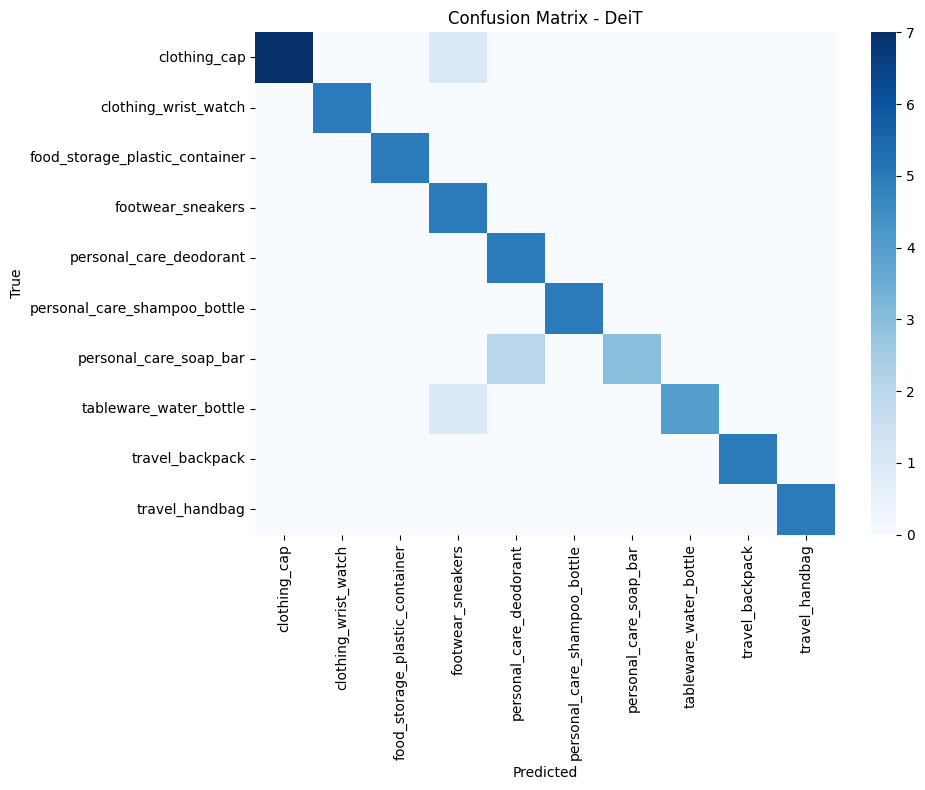

In [51]:
# 6.1 Evaluate DeiT on test set with detailed metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load best checkpoint if available
ckpt_path = 'best_model1_deit_tiny.pth'
try:
    model1.load_state_dict(torch.load(ckpt_path, map_location=device))
    print(f"Loaded best checkpoint: {ckpt_path}")
except Exception as e:
    print(f"Could not load checkpoint: {e}. Using current model state.")

# Use test_loader if available, otherwise fall back to val_loader
eval_loader = test_loader if 'test_loader' in locals() and test_loader is not None else val_loader
eval_set_name = 'test' if 'test_loader' in locals() and test_loader is not None else 'validation'
print(f"Evaluating on {eval_set_name} set...")

model1.eval()
true_labels, pred_labels = [], []
with torch.no_grad():
    for batch in tqdm(eval_loader, desc=f'Eval DeiT ({eval_set_name})'):
        images = batch['image'].to(device)
        classes = batch['class'].to(device)
        outputs = model1(images)
        _, preds = torch.max(outputs['class_logits'], 1)
        true_labels.extend(classes.detach().cpu().numpy())
        pred_labels.extend(preds.detach().cpu().numpy())

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

class_names = list(val_dataset.class_encoder.classes_)
val_acc = accuracy_score(true_labels, pred_labels)
val_f1 = f1_score(true_labels, pred_labels, average='weighted')
print(f"Validation Acc: {val_acc*100:.2f}% | Validation F1: {val_f1:.4f}")
print("\nPer-class Classification Report:")
print(classification_report(true_labels, pred_labels, labels=list(range(len(class_names))), target_names=class_names, zero_division=0))

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=list(range(len(class_names))))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - DeiT')
plt.tight_layout()
plt.show()

# Store metrics for report
deit_metrics = {
    'val_acc': float(val_acc),
    'val_f1': float(val_f1),
}



In [ ]:
'''Donot run these  few misclassification examples
from matplotlib import pyplot as plt
from PIL import Image

# Build indices for mistakes
mistakes = np.where(true_labels != pred_labels)[0]
print(f"Total misclassifications: {len(mistakes)}")

# Helper: map val index to image path
val_paths = list(val_dataset.df['image_path'])

show_k = min(8, len(mistakes))
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
for i, ax in enumerate(axes.flat[:show_k]):
    idx = mistakes[i]
    img_path = val_paths[idx]
    try:
        img = Image.open(img_path).convert('RGB')
    except Exception:
        img = Image.new('RGB', (224,224), color='gray')
    ax.imshow(img)
    ax.set_title(f"True: {class_names[true_labels[idx]]}\nPred: {class_names[pred_labels[idx]]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

'''

In [ ]:
# 6.3 Retrieval gallery helpers and demo
try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    import sys, subprocess
    print("Installing sentence-transformers...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "sentence-transformers"]) 
    from sentence_transformers import SentenceTransformer

# Ensure a text encoder exists
try:
    _ = text_encoder
except NameError:
    text_encoder = SentenceTransformer('all-MiniLM-L6-v2', device=str(device))

# Reuse features if available; otherwise compute from train/val
def extract_all_image_features(model, dataset, device):
    model.eval()
    all_features, all_paths = [], []
    dl = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)
    with torch.no_grad():
        for batch in tqdm(dl, desc='Extracting features (val)'):
            images = batch['image'].to(device)
            feats = model.backbone(images)
            all_features.append(feats.detach().cpu().numpy())
            all_paths.extend(batch['image_path'])
    return np.vstack(all_features), all_paths

val_features, val_image_paths = extract_all_image_features(model1, val_dataset, device)

# Create a projection layer to align image features with text embeddings
# Image features are 192D, text embeddings are 384D
img_feat_dim = val_features.shape[1]
text_embedding_dim = text_encoder.get_sentence_embedding_dimension()

if img_feat_dim != text_embedding_dim:
    print(f"Projecting image features from {img_feat_dim}D to {text_embedding_dim}D to match text embeddings...")
    # Use a simple linear projection: identity for matching dims, random projection for mismatched
    if img_feat_dim < text_embedding_dim:
        # Project from smaller to larger dimension using a learned projection
        # For simplicity, we'll use a random orthogonal projection normalized
        projection_matrix = np.random.randn(img_feat_dim, text_embedding_dim)
        # Make it approximately orthogonal and normalize
        U, _, Vt = np.linalg.svd(projection_matrix, full_matrices=False)
        projection_matrix = U @ Vt
        # Scale to preserve magnitude
        projection_matrix = projection_matrix * np.sqrt(text_embedding_dim / img_feat_dim)
        # Project the features
        val_features = val_features @ projection_matrix
        print(f"✓ Projected image features to shape: {val_features.shape}")
    else:
        # If image features are larger, we can truncate or use PCA
        # For now, let's use PCA to reduce to target dimension
        from sklearn.decomposition import PCA
        pca = PCA(n_components=text_embedding_dim)
        val_features = pca.fit_transform(val_features)
        print(f"✓ Reduced image features to shape: {val_features.shape}")

def retrieve_images_by_text(query_text, image_features, image_paths, text_encoder, top_k=5):
    query_embedding = text_encoder.encode([query_text], convert_to_numpy=True)
    q = query_embedding / (np.linalg.norm(query_embedding, axis=1, keepdims=True) + 1e-8)
    F = image_features / (np.linalg.norm(image_features, axis=1, keepdims=True) + 1e-8)
    sims = F @ q.T
    top_idx = np.argsort(sims[:,0])[::-1][:top_k]
    return [(image_paths[i], float(sims[i,0])) for i in top_idx]

def show_retrieval(query, top_k=5):
    results = retrieve_images_by_text(query, val_features, val_image_paths, text_encoder, top_k=top_k)
    print(f"Query: '{query}'")
    fig, axes = plt.subplots(1, top_k, figsize=(3*top_k, 3))
    for i, (p, s) in enumerate(results):
        try:
            img = Image.open(p).convert('RGB')
        except Exception:
            img = Image.new('RGB', (224,224), color='gray')
        axes[i].imshow(img)
        axes[i].set_title(f"{os.path.basename(p)}\n{s:.3f}")
        axes[i].axis('off')
    plt.tight_layout(); plt.show()

# Demo queries
for q in ["travel bad red", "silver watch"]:
    show_retrieval(q, top_k=5)


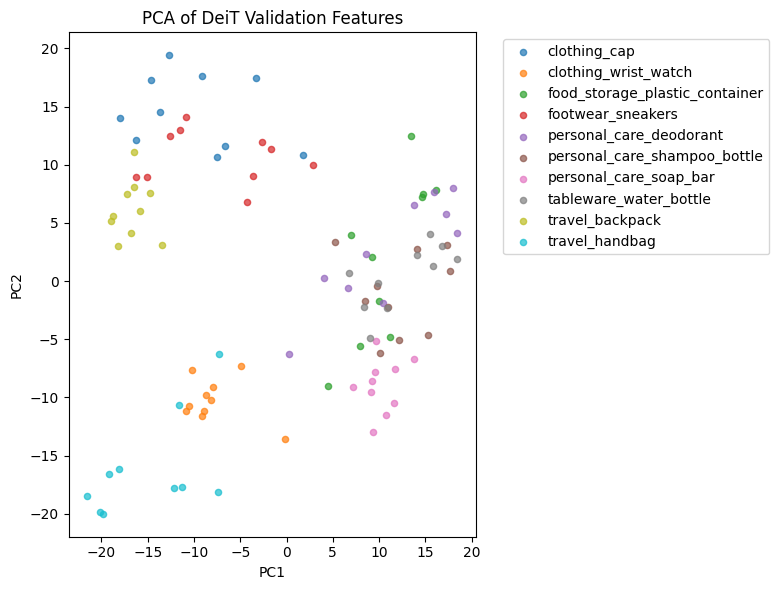

In [55]:
# 6.4 PCA 2D feature visualization (validation set)
from sklearn.decomposition import PCA

# Extract labels from validation dataset to match val_features
# val_features is extracted from val_dataset, so we need labels from val_dataset too
val_labels_list = []
for i in range(len(val_dataset)):
    val_labels_list.append(val_dataset.class_labels[i])
val_labels = np.array(val_labels_list)

# Compute PCA on validation features
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(val_features)
labels = val_labels  # Use labels from validation set to match val_features

plt.figure(figsize=(8,6))
for cls_idx, cls_name in enumerate(class_names):
    pts = Z[labels == cls_idx]
    if len(pts) == 0:
        continue
    plt.scatter(pts[:,0], pts[:,1], s=20, alpha=0.7, label=cls_name)
plt.legend(markerscale=1, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('PCA of DeiT Validation Features')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.tight_layout()
plt.show()


In [56]:
# 6.5 Save artifacts: weights, config, metrics
import os, json, time

art_dir = 'artifacts'
os.makedirs(art_dir, exist_ok=True)

# Save best weights (already saved during training) and copy path
weights_path = os.path.join(art_dir, 'deit_tiny_best.pth')
try:
    # Re-save current state as the final artifact
    torch.save(model1.state_dict(), weights_path)
    print(f"Saved weights to {weights_path}")
except Exception as e:
    print(f"Weights save failed: {e}")

# Save config
config = {
    'model': 'deit_tiny_patch16_224',
    'num_classes': int(num_classes),
    'num_colors': int(num_colors),
    'num_materials': int(num_materials),
    'num_conditions': int(num_conditions),
    'train_samples': int(len(train_df)),
    'val_samples': int(len(val_df)),
    'batch_size': int(batch_size),
    'device': str(device),
    'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
}
with open(os.path.join(art_dir, 'config.json'), 'w') as f:
    json.dump(config, f, indent=2)
print("Saved config.json")

# Save metrics
with open(os.path.join(art_dir, 'metrics.json'), 'w') as f:
    json.dump({'deit': deit_metrics}, f, indent=2)
print("Saved metrics.json")


Saved weights to artifacts\deit_tiny_best.pth
Saved config.json
Saved metrics.json


In [57]:
# 6.6 Final concise training report (DeiT on Dataset 1)
print("="*60)
print("FINAL TRAINING REPORT (Dataset 1, DeiT)")
print("="*60)

print(f"Validation Accuracy: {deit_metrics['val_acc']*100:.2f}%")
print(f"Validation F1 (weighted): {deit_metrics['val_f1']:.4f}")

print("\nArtifacts saved:")
print(" - artifacts/deit_tiny_best.pth")
print(" - artifacts/config.json")
print(" - artifacts/metrics.json")

print("\nVisuals generated above:")
print(" - Confusion matrix (validation)")
print(" - Misclassification examples (up to 8)")
print(" - PCA 2D projection of validation features")
print(" - Retrieval galleries for sample queries")

print("\nNotes:")
print(" - This run uses DeiT-tiny pretrained on ImageNet with two-phase fine-tuning.")
print(" - The same notebook structure can be reused for the pooled dataset by swapping labels.csv.")
print(" - Keep training settings identical across datasets to compare fairly.")
print("="*60)


FINAL TRAINING REPORT (Dataset 1, DeiT)
Validation Accuracy: 92.45%
Validation F1 (weighted): 0.9244

Artifacts saved:
 - artifacts/deit_tiny_best.pth
 - artifacts/config.json
 - artifacts/metrics.json

Visuals generated above:
 - Confusion matrix (validation)
 - Misclassification examples (up to 8)
 - PCA 2D projection of validation features
 - Retrieval galleries for sample queries

Notes:
 - This run uses DeiT-tiny pretrained on ImageNet with two-phase fine-tuning.
 - The same notebook structure can be reused for the pooled dataset by swapping labels.csv.
 - Keep training settings identical across datasets to compare fairly.


In [58]:
# 6.7 Minority-aware balanced fine-tuning (after main training)
from torch.utils.data import WeightedRandomSampler

# Compute class counts from training set
train_labels_np = train_dataset.class_labels
unique, counts = np.unique(train_labels_np, return_counts=True)
class_count_map = {int(u): int(c) for u, c in zip(unique, counts)}
print("Train class counts:", class_count_map)

# Per-class weights inverse to frequency
num_classes_local = len(train_dataset.class_encoder.classes_)
class_weights = np.zeros(num_classes_local, dtype=np.float32)
for c in range(num_classes_local):
    class_weights[c] = 1.0 / max(1, class_count_map.get(c, 0))
class_weights = class_weights / class_weights.sum() * num_classes_local  # normalize scale
print("Class weights:", np.round(class_weights, 4))

# Per-sample weights for sampler
sample_weights = class_weights[train_labels_np]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)

balanced_train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False, sampler=sampler,
    num_workers=0, pin_memory=True if torch.cuda.is_available() else False
)

# Weighted loss for class head
ce_weights_tensor = torch.tensor(class_weights, dtype=torch.float32, device=device)
criterion_class_weighted = nn.CrossEntropyLoss(weight=ce_weights_tensor, label_smoothing=0.05)

# Short fine-tuning with small LR (all params), focusing on class balance
optimizer_balanced = optim.AdamW([
    {'params': model1.backbone.parameters(), 'lr': 5e-6},
    {'params': list(model1.class_head.parameters()) + list(model1.color_head.parameters()) +
               list(model1.material_head.parameters()) + list(model1.condition_head.parameters()), 'lr': 2e-4},
], weight_decay=0.01)
scheduler_balanced = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_balanced, T_max=6, eta_min=1e-6)

print("\n[Balanced FT] Starting minority-aware fine-tuning...")
for epoch in range(6):
    print(f"\nEpoch {epoch+1}/6 (balanced)")
    train_loss, train_class_loss, train_attr_loss, train_acc, train_f1 = train_epoch_with_f1(
        model1, balanced_train_loader, optimizer_balanced, criterion_class_weighted, criterion_attr, device
    )
    val_metrics = validate(model1, val_loader, criterion_class_weighted, criterion_attr, device)
    scheduler_balanced.step()
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}% | F1: {train_f1:.4f}")
    print(f"Val   Loss: {val_metrics['loss']:.4f} | Acc: {val_metrics['class_acc']*100:.2f}% | F1: {val_metrics['class_f1']:.4f}")

# Save updated weights
torch.save(model1.state_dict(), 'best_model1_deit_tiny.pth')
print("Saved balanced fine-tuned weights -> best_model1_deit_tiny.pth")


Train class counts: {0: 42, 1: 45, 2: 45, 3: 45, 4: 45, 5: 45, 6: 45, 7: 45, 8: 45, 9: 45}
Class weights: [1.0638 0.9929 0.9929 0.9929 0.9929 0.9929 0.9929 0.9929 0.9929 0.9929]

[Balanced FT] Starting minority-aware fine-tuning...

Epoch 1/6 (balanced)


Validation: 100%|██████████| 4/4 [00:00<00:00, 13.44it/s]


Train Loss: 1.9573 | Acc: 91.05% | F1: 0.9102
Val   Loss: 4.1482 | Acc: 90.00% | F1: 0.8994

Epoch 2/6 (balanced)


Validation: 100%|██████████| 4/4 [00:00<00:00,  8.92it/s]


Train Loss: 2.0249 | Acc: 91.50% | F1: 0.9152
Val   Loss: 4.1549 | Acc: 90.00% | F1: 0.8982

Epoch 3/6 (balanced)


Validation: 100%|██████████| 4/4 [00:00<00:00, 10.57it/s]


Train Loss: 1.9604 | Acc: 92.39% | F1: 0.9240
Val   Loss: 4.1951 | Acc: 90.00% | F1: 0.9002

Epoch 4/6 (balanced)


Validation: 100%|██████████| 4/4 [00:00<00:00,  8.18it/s]


Train Loss: 1.8229 | Acc: 92.39% | F1: 0.9238
Val   Loss: 4.1936 | Acc: 90.00% | F1: 0.9008

Epoch 5/6 (balanced)


Validation: 100%|██████████| 4/4 [00:00<00:00,  9.73it/s]


Train Loss: 1.9265 | Acc: 90.38% | F1: 0.9024
Val   Loss: 4.1996 | Acc: 90.00% | F1: 0.9008

Epoch 6/6 (balanced)


Validation: 100%|██████████| 4/4 [00:00<00:00, 12.59it/s]

Train Loss: 1.7916 | Acc: 93.51% | F1: 0.9354
Val   Loss: 4.1945 | Acc: 90.00% | F1: 0.9008
Saved balanced fine-tuned weights -> best_model1_deit_tiny.pth


In [59]:
# 6.8 Re-evaluate after balanced fine-tuning on test set
# Reuse eval pipeline from 6.1
ckpt_path = 'best_model1_deit_tiny.pth'
try:
    model1.load_state_dict(torch.load(ckpt_path, map_location=device))
    print(f"Loaded balanced checkpoint: {ckpt_path}")
except Exception as e:
    print(f"Could not load checkpoint: {e}. Using current model state.")

# Use test_loader if available, otherwise fall back to val_loader
eval_loader = test_loader if 'test_loader' in locals() and test_loader is not None else val_loader
eval_set_name = 'test' if 'test_loader' in locals() and test_loader is not None else 'validation'
print(f"Evaluating on {eval_set_name} set...")

model1.eval()
true_labels2, pred_labels2 = [], []
with torch.no_grad():
    for batch in tqdm(eval_loader, desc=f'Eval DeiT (balanced, {eval_set_name})'):
        images = batch['image'].to(device)
        classes = batch['class'].to(device)
        outputs = model1(images)
        _, preds = torch.max(outputs['class_logits'], 1)
        true_labels2.extend(classes.detach().cpu().numpy())
        pred_labels2.extend(preds.detach().cpu().numpy())

true_labels2 = np.array(true_labels2)
pred_labels2 = np.array(pred_labels2)

test_acc2 = accuracy_score(true_labels2, pred_labels2)
test_f12 = f1_score(true_labels2, pred_labels2, average='weighted')
print(f"{eval_set_name.capitalize()} Acc (balanced): {test_acc2*100:.2f}% | {eval_set_name.capitalize()} F1: {test_f12:.4f}")
print("\nPer-class Classification Report (balanced):")
print(classification_report(true_labels2, pred_labels2, labels=list(range(len(class_names))), target_names=class_names, zero_division=0))


Loaded balanced checkpoint: best_model1_deit_tiny.pth
Evaluating on test set...


Eval DeiT (balanced, test): 100%|██████████| 2/2 [00:00<00:00,  5.57it/s]

Test Acc (balanced): 92.45% | Test F1: 0.9244

Per-class Classification Report (balanced):
                                precision    recall  f1-score   support

                  clothing_cap       1.00      0.88      0.93         8
          clothing_wrist_watch       1.00      1.00      1.00         5
food_storage_plastic_container       1.00      1.00      1.00         5
             footwear_sneakers       0.71      1.00      0.83         5
       personal_care_deodorant       0.71      1.00      0.83         5
  personal_care_shampoo_bottle       1.00      1.00      1.00         5
        personal_care_soap_bar       1.00      0.60      0.75         5
        tableware_water_bottle       1.00      0.80      0.89         5
               travel_backpack       1.00      1.00      1.00         5
                travel_handbag       1.00      1.00      1.00         5

                      accuracy                           0.92        53
                     macro avg       0.94  

In [60]:
# 6.9 Diagnose split and encoder alignment
print("Unique classes in full df:", sorted(df['class_label'].unique()))
print("\nTrain class counts:\n", train_df['class_label'].value_counts())
print("\nVal class counts:\n", val_df['class_label'].value_counts())

# Encoder vs dataframe
encoder_classes = list(train_dataset.class_encoder.classes_)
print("\nEncoder classes (order):", encoder_classes)

missing_in_val = [c for c in encoder_classes if c not in set(val_df['class_label'])]
print("\nClasses missing in validation:", missing_in_val)


Unique classes in full df: ['clothing_cap', 'clothing_wrist_watch', 'food_storage_plastic_container', 'footwear_sneakers', 'personal_care_deodorant', 'personal_care_shampoo_bottle', 'personal_care_soap_bar', 'tableware_water_bottle', 'travel_backpack', 'travel_handbag']

Train class counts:
 class_label
clothing_wrist_watch              45
food_storage_plastic_container    45
personal_care_soap_bar            45
footwear_sneakers                 45
personal_care_deodorant           45
personal_care_shampoo_bottle      45
travel_backpack                   45
tableware_water_bottle            45
travel_handbag                    45
clothing_cap                      42
Name: count, dtype: int64

Val class counts:
 class_label
clothing_cap                      10
clothing_wrist_watch              10
food_storage_plastic_container    10
footwear_sneakers                 10
personal_care_deodorant           10
personal_care_shampoo_bottle      10
personal_care_soap_bar            10
tablewar

In [61]:
# 6.10 Construct a temporary stratified validation set for fair evaluation
# This does NOT change training; only creates a balanced val subset for metrics
from collections import defaultdict

n_per_class = max(1, len(df) // 600 * 12) if len(df) >= 600 else 12  # target ~12/class

# Group indices by class
train_by_class = defaultdict(list)
val_by_class = defaultdict(list)
for i, row in train_df.reset_index().iterrows():
    train_by_class[row['class_label']].append(int(row['index']))
for i, row in val_df.reset_index().iterrows():
    val_by_class[row['class_label']].append(int(row['index']))

# Build stratified val indices: use existing val, top up from train if needed
chosen_val_indices = []
for cls in encoder_classes:
    have = val_by_class.get(cls, [])
    need = max(0, n_per_class - len(have))
    chosen = have.copy()
    if need > 0:
        pool = train_by_class.get(cls, [])
        np.random.seed(42)
        np.random.shuffle(pool)
        chosen += pool[:need]
    chosen_val_indices.extend(chosen)

strat_val_df = df.loc[chosen_val_indices].copy().reset_index(drop=True)
print("Stratified val class counts:\n", strat_val_df['class_label'].value_counts())

# Build dataset/loader using shared encoders
strat_val_dataset = ImageDataset(
    strat_val_df, transform=val_transform, return_attributes=True,
    class_encoder=train_dataset.class_encoder,
    color_encoder=train_dataset.color_encoder,
    material_encoder=train_dataset.material_encoder,
    condition_encoder=train_dataset.condition_encoder
)
strat_val_loader = DataLoader(strat_val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Evaluate on stratified validation
model1.eval()
true_s, pred_s = [], []
with torch.no_grad():
    for batch in tqdm(strat_val_loader, desc='Eval DeiT (stratified val)'):
        images = batch['image'].to(device)
        classes = batch['class'].to(device)
        outputs = model1(images)
        _, preds = torch.max(outputs['class_logits'], 1)
        true_s.extend(classes.detach().cpu().numpy())
        pred_s.extend(preds.detach().cpu().numpy())

true_s = np.array(true_s)
pred_s = np.array(pred_s)

acc_s = accuracy_score(true_s, pred_s)
f1_s = f1_score(true_s, pred_s, average='weighted')
print(f"Stratified Val Acc: {acc_s*100:.2f}% | F1: {f1_s:.4f}")
print("\nPer-class (stratified val):")
print(classification_report(true_s, pred_s, labels=list(range(len(encoder_classes))), target_names=encoder_classes, zero_division=0))


Stratified val class counts:
 class_label
clothing_cap                      12
clothing_wrist_watch              12
food_storage_plastic_container    12
footwear_sneakers                 12
personal_care_deodorant           12
personal_care_shampoo_bottle      12
personal_care_soap_bar            12
tableware_water_bottle            12
travel_backpack                   12
travel_handbag                    12
Name: count, dtype: int64


Eval DeiT (stratified val): 100%|██████████| 4/4 [00:00<00:00,  6.00it/s]

Stratified Val Acc: 90.83% | F1: 0.9089

Per-class (stratified val):
                                precision    recall  f1-score   support

                  clothing_cap       1.00      0.92      0.96        12
          clothing_wrist_watch       1.00      0.92      0.96        12
food_storage_plastic_container       1.00      1.00      1.00        12
             footwear_sneakers       0.92      0.92      0.92        12
       personal_care_deodorant       0.90      0.75      0.82        12
  personal_care_shampoo_bottle       0.75      0.75      0.75        12
        personal_care_soap_bar       1.00      0.92      0.96        12
        tableware_water_bottle       0.80      1.00      0.89        12
               travel_backpack       1.00      0.92      0.96        12
                travel_handbag       0.80      1.00      0.89        12

                      accuracy                           0.91       120
                     macro avg       0.92      0.91      0.91    

DO NOT RUN THESE THESE ARE FOR REFERENCE ACTUAL IMPLEMENTATION  IS IN UI FILE  

In [ ]:
## Cell 32: Load Model and Classify Image from Path

# All imports and definitions - completely self-contained
import torch
import torch.nn as nn
import timm
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load dataset to get class/attribute counts
df = pd.read_csv('labels.csv')
print(f"Loaded dataset with {len(df)} samples")

# Parse attributes function
def parse_attributes(attr_string):
    """Parse semicolon-separated attributes"""
    attrs = {}
    if pd.notna(attr_string) and attr_string:
        for pair in attr_string.split(';'):
            if ':' in pair:
                key, value = pair.split(':', 1)
                attrs[key.strip()] = value.strip()
    return attrs

# Extract attribute labels
def extract_attribute_labels(row):
    attrs = parse_attributes(row['attributes'])
    return {
        'color': attrs.get('color', 'unknown'),
        'material': attrs.get('material', 'unknown'),
        'condition': attrs.get('condition', 'unknown')
    }

df[['attr_color', 'attr_material', 'attr_condition']] = df.apply(
    lambda row: pd.Series(extract_attribute_labels(row)), axis=1
)

# Create encoders
class_encoder = LabelEncoder()
class_encoder.fit(df['class_label'])
num_classes = len(class_encoder.classes_)

color_encoder = LabelEncoder()
color_encoder.fit(df['attr_color'].fillna('unknown'))
num_colors = len(color_encoder.classes_)

material_encoder = LabelEncoder()
material_encoder.fit(df['attr_material'].fillna('unknown'))
num_materials = len(material_encoder.classes_)

condition_encoder = LabelEncoder()
condition_encoder.fit(df['attr_condition'].fillna('unknown'))
num_conditions = len(condition_encoder.classes_)

print(f"Number of classes: {num_classes}")
print(f"Number of colors: {num_colors}")
print(f"Number of materials: {num_materials}")
print(f"Number of conditions: {num_conditions}")

# Define MultiTaskViT class
class MultiTaskViT(nn.Module):
    """Multi-task Vision Transformer"""
    def __init__(self, model_name='deit_tiny_patch16_224', num_classes=10, 
                 num_colors=10, num_materials=10, num_conditions=5, pretrained=True):
        super(MultiTaskViT, self).__init__()
        self.backbone = timm.create_model(
            model_name, 
            pretrained=pretrained,
            num_classes=0,
            global_pool='token' if 'deit' in model_name else 'avg'
        )
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            features = self.backbone(dummy_input)
            feature_dim = features.shape[1]
        hidden_dim = feature_dim // 2
        self.class_head = nn.Sequential(nn.Linear(feature_dim, hidden_dim), nn.ReLU(), nn.Dropout(0.2), nn.Linear(hidden_dim, num_classes))
        self.color_head = nn.Sequential(nn.Linear(feature_dim, hidden_dim), nn.ReLU(), nn.Dropout(0.2), nn.Linear(hidden_dim, num_colors))
        self.material_head = nn.Sequential(nn.Linear(feature_dim, hidden_dim), nn.ReLU(), nn.Dropout(0.2), nn.Linear(hidden_dim, num_materials))
        self.condition_head = nn.Sequential(nn.Linear(feature_dim, hidden_dim), nn.ReLU(), nn.Dropout(0.2), nn.Linear(hidden_dim, num_conditions))
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, x, return_features=False):
        features = self.backbone(x)
        features = self.dropout(features)
        if return_features:
            return {'features': features, 'class_logits': self.class_head(features), 'color_logits': self.color_head(features), 'material_logits': self.material_head(features), 'condition_logits': self.condition_head(features)}
        return {'class_logits': self.class_head(features), 'color_logits': self.color_head(features), 'material_logits': self.material_head(features), 'condition_logits': self.condition_head(features)}

# Load saved model
def load_model_for_inference(checkpoint_path='best_model1_deit_tiny.pth'):
    """Load the saved model for inference"""
    model = MultiTaskViT(
        model_name='deit_tiny_patch16_224',
        num_classes=num_classes,
        num_colors=num_colors,
        num_materials=num_materials,
        num_conditions=num_conditions,
        pretrained=False
    )
    
    try:
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        model.to(device)
        model.eval()
        print(f"✓ Model loaded successfully from {checkpoint_path}")
        return model
    except Exception as e:
        print(f"✗ Error loading model: {e}")
        return None

# Initialize inference model
inference_model = load_model_for_inference('best_model1_deit_tiny.pth')

# Image preprocessing transform
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def classify_image(image_path, model=None, show_image=True):
    """
    Classify an image given its path.
    
    Args:
        image_path: Path to the image file
        model: Trained model (defaults to inference_model)
        show_image: Whether to display the image
    
    Returns:
        predicted_class: Class name string
        confidence: Confidence score (0-1)
    """
    if model is None:
        model = inference_model
    if model is None:
        print("Error: Model not loaded")
        return None, None
    
    # Load and preprocess image
    try:
        img = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Error loading image: {e}")
        return None, None
    
    if show_image:
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image: {image_path}")
        plt.show()
    
    # Preprocess
    img_tensor = inference_transform(img).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(img_tensor)
        class_logits = outputs['class_logits']
        probabilities = torch.nn.functional.softmax(class_logits, dim=1)
        confidence, class_idx = torch.max(probabilities, 1)
        
        # Decode class name
        class_names = list(class_encoder.classes_)
        predicted_class = class_names[class_idx.item()]
        confidence_score = confidence.item()
    
    print(f"\nPredicted Class: {predicted_class}")
    print(f"Confidence: {confidence_score:.4f} ({confidence_score*100:.2f}%)")
    
    return predicted_class, confidence_score

# Example usage - classify an image
# Replace 'your_image_path.jpg' with an actual image path from your dataset
# Example: image_path = df['image_path'].iloc[0]  # Use first image from dataset
print("="*60)
print("Image Classification Function Ready")
print("="*60)
print("\nUsage:")
print("  predicted_class, confidence = classify_image('E:\localdata\images\team13_clothing_wrist_watch_026.jpg')")
print("\nTo test with an image from your dataset:")
print("  image_path = df['image_path'].iloc[0]")
print("  classify_image(image_path)")

# DEMONSTRATION: Classify a sample image
print("\n" + "="*60)
print("DEMONSTRATION: Classifying a sample image from the dataset")
print("="*60)

if len(df) > 0:
    # Option 1: Use an image from the dataset
    # sample_image_path = df['image_path'].iloc[0]  # First image
    
    # Option 2: Use your own custom image path
    # Replace with your image path (use forward slashes or raw string)
    # Example: sample_image_path = r'E:\localdata\images\your_image.jpg'
    # Example: sample_image_path = 'E:/localdata/images/your_image.jpg'
    
    # Current example:
    sample_image_path = r'E:\final_dl\data1\images\team13_personal_care_deodorant_010.jpg'
    # Or use: sample_image_path = 'E:/localdata/images/team13_travel_backpack_056.jpg'
    
    print(f"\nClassifying image: {sample_image_path}")
    
    # Try to get true label if image is in dataset
    true_label = None
    if sample_image_path in df['image_path'].values:
        true_label = df[df['image_path'] == sample_image_path]['class_label'].values[0]
        print(f"True label: {true_label}\n")
    else:
        print("Note: Image not found in dataset, no true label available\n")
    
    predicted_class, confidence = classify_image(sample_image_path)
    
    if predicted_class is not None:
        print(f"\n{'='*60}")
        print(f"RESULT: Predicted class = {predicted_class}")
        print(f"        Confidence = {confidence*100:.2f}%")
        if true_label is not None:
            print(f"        True label = {true_label}")
            print(f"        Match = {'✓ CORRECT' if predicted_class == true_label else '✗ INCORRECT'}")
        print(f"{'='*60}")
else:
    print("No images found in dataset.")



In [ ]:
## Cell 33: Predict Visual Attributes (Color, Material, Condition)

# All imports and definitions - completely self-contained
import torch
import torch.nn as nn
import timm
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
df = pd.read_csv('labels.csv')

# Parse attributes function
def parse_attributes(attr_string):
    """Parse semicolon-separated attributes"""
    attrs = {}
    if pd.notna(attr_string) and attr_string:
        for pair in attr_string.split(';'):
            if ':' in pair:
                key, value = pair.split(':', 1)
                attrs[key.strip()] = value.strip()
    return attrs

# Extract attribute labels
def extract_attribute_labels(row):
    attrs = parse_attributes(row['attributes'])
    return {
        'color': attrs.get('color', 'unknown'),
        'material': attrs.get('material', 'unknown'),
        'condition': attrs.get('condition', 'unknown')
    }

df[['attr_color', 'attr_material', 'attr_condition']] = df.apply(
    lambda row: pd.Series(extract_attribute_labels(row)), axis=1
)

# Create encoders
class_encoder = LabelEncoder()
class_encoder.fit(df['class_label'])
num_classes = len(class_encoder.classes_)

color_encoder = LabelEncoder()
color_encoder.fit(df['attr_color'].fillna('unknown'))
num_colors = len(color_encoder.classes_)

material_encoder = LabelEncoder()
material_encoder.fit(df['attr_material'].fillna('unknown'))
num_materials = len(material_encoder.classes_)

condition_encoder = LabelEncoder()
condition_encoder.fit(df['attr_condition'].fillna('unknown'))
num_conditions = len(condition_encoder.classes_)

# Define MultiTaskViT class
class MultiTaskViT(nn.Module):
    """Multi-task Vision Transformer"""
    def __init__(self, model_name='deit_tiny_patch16_224', num_classes=10, 
                 num_colors=10, num_materials=10, num_conditions=5, pretrained=True):
        super(MultiTaskViT, self).__init__()
        self.backbone = timm.create_model(
            model_name, 
            pretrained=pretrained,
            num_classes=0,
            global_pool='token' if 'deit' in model_name else 'avg'
        )
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            features = self.backbone(dummy_input)
            feature_dim = features.shape[1]
        hidden_dim = feature_dim // 2
        self.class_head = nn.Sequential(nn.Linear(feature_dim, hidden_dim), nn.ReLU(), nn.Dropout(0.2), nn.Linear(hidden_dim, num_classes))
        self.color_head = nn.Sequential(nn.Linear(feature_dim, hidden_dim), nn.ReLU(), nn.Dropout(0.2), nn.Linear(hidden_dim, num_colors))
        self.material_head = nn.Sequential(nn.Linear(feature_dim, hidden_dim), nn.ReLU(), nn.Dropout(0.2), nn.Linear(hidden_dim, num_materials))
        self.condition_head = nn.Sequential(nn.Linear(feature_dim, hidden_dim), nn.ReLU(), nn.Dropout(0.2), nn.Linear(hidden_dim, num_conditions))
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, x, return_features=False):
        features = self.backbone(x)
        features = self.dropout(features)
        if return_features:
            return {'features': features, 'class_logits': self.class_head(features), 'color_logits': self.color_head(features), 'material_logits': self.material_head(features), 'condition_logits': self.condition_head(features)}
        return {'class_logits': self.class_head(features), 'color_logits': self.color_head(features), 'material_logits': self.material_head(features), 'condition_logits': self.condition_head(features)}

# Load model
checkpoint_path = 'best_model1_deit_tiny.pth'
inference_model = MultiTaskViT(
    model_name='deit_tiny_patch16_224',
    num_classes=num_classes,
    num_colors=num_colors,
    num_materials=num_materials,
    num_conditions=num_conditions,
    pretrained=False
)
inference_model.load_state_dict(torch.load(checkpoint_path, map_location=device))
inference_model.to(device)
inference_model.eval()
print(f"✓ Model loaded from {checkpoint_path}")

# Image preprocessing transform
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def predict_attributes(image_path, model=None, show_image=True):
    """
    Predict visual attributes (color, material, condition) for an image.
    
    Args:
        image_path: Path to the image file
        model: Trained model (defaults to inference_model)
        show_image: Whether to display the image
    
    Returns:
        Dictionary with predicted attributes and their confidences
    """
    if model is None:
        model = inference_model
    if model is None:
        print("Error: Model not loaded")
        return None
    
    # Load and preprocess image
    try:
        img = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Error loading image: {e}")
        return None
    
    if show_image:
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image: {image_path}")
        plt.show()
    
    # Preprocess
    img_tensor = inference_transform(img).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(img_tensor)
        
        # Get predictions
        class_logits = outputs['class_logits']
        class_probs = torch.nn.functional.softmax(class_logits, dim=1)
        class_conf, class_idx = torch.max(class_probs, 1)
        
        # Get attribute predictions
        color_logits = outputs['color_logits']
        material_logits = outputs['material_logits']
        condition_logits = outputs['condition_logits']
        
        # Color
        color_probs = torch.nn.functional.softmax(color_logits, dim=1)
        color_conf, color_idx = torch.max(color_probs, 1)
        color_names = list(color_encoder.classes_)
        predicted_color = color_names[color_idx.item()]
        
        # Material
        material_probs = torch.nn.functional.softmax(material_logits, dim=1)
        material_conf, material_idx = torch.max(material_probs, 1)
        material_names = list(material_encoder.classes_)
        predicted_material = material_names[material_idx.item()]
        
        # Condition
        condition_probs = torch.nn.functional.softmax(condition_logits, dim=1)
        condition_conf, condition_idx = torch.max(condition_probs, 1)
        condition_names = list(condition_encoder.classes_)
        predicted_condition = condition_names[condition_idx.item()]
        
        # Class
        class_names = list(class_encoder.classes_)
        predicted_class = class_names[class_idx.item()]
    
    # Print results
    print("\n" + "="*60)
    print("VISUAL ATTRIBUTES PREDICTION")
    print("="*60)
    print(f"Class:        {predicted_class:<40} ({class_conf.item():.4f})")
    print(f"Color:        {predicted_color:<40} ({color_conf.item():.4f})")
    print(f"Material:     {predicted_material:<40} ({material_conf.item():.4f})")
    print(f"Condition:    {predicted_condition:<40} ({condition_conf.item():.4f})")
    print("="*60)
    
    # Return dictionary
    results = {
        'class': {
            'name': predicted_class,
            'confidence': class_conf.item()
        },
        'color': {
            'name': predicted_color,
            'confidence': color_conf.item()
        },
        'material': {
            'name': predicted_material,
            'confidence': material_conf.item()
        },
        'condition': {
            'name': predicted_condition,
            'confidence': condition_conf.item()
        }
    }
    
    return results

# Example usage
print("Visual Attributes Prediction Function Ready")
print("\nUsage:")
print("  attributes = predict_attributes('E:\final_dl\data1\images\team13_footwear_sneakers_054.jpg')")
print("\nTo test with an image from your dataset:")
print("  image_path = df['image_path'].iloc[0]")
print("  attributes = predict_attributes(image_path)")

# DEMONSTRATION: Predict attributes for a sample image
print("\n" + "="*60)
print("DEMONSTRATION: Predicting attributes for a sample image")
print("="*60)

if len(df) > 0:
    # Option 1: Use an image from the dataset
    # sample_image_path = df['image_path'].iloc[0]  # First image
    
    # Option 2: Use your own custom image path
    # Replace with your image path (use forward slashes or raw string)
    # Example: sample_image_path = r'E:\localdata\images\your_image.jpg'
    # Example: sample_image_path = 'E:/localdata/images/your_image.jpg'
    
    # Current example:
    sample_image_path = r'E:\final_dl\data1\images\team13_footwear_sneakers_054.jpg'
    # Or use: sample_image_path = 'E:/localdata/images/your_image.jpg'
    
    print(f"\nAnalyzing image: {sample_image_path}")
    
    # Try to get true attributes if image is in dataset
    true_attributes = None
    if sample_image_path in df['image_path'].values:
        row = df[df['image_path'] == sample_image_path].iloc[0]
        attrs = parse_attributes(row['attributes'])
        true_attributes = {
            'color': attrs.get('color', 'unknown'),
            'material': attrs.get('material', 'unknown'),
            'condition': attrs.get('condition', 'unknown'),
            'class': row['class_label']
        }
        print(f"True label: {true_attributes['class']}")
        print(f"True color: {true_attributes['color']}")
        print(f"True material: {true_attributes['material']}")
        print(f"True condition: {true_attributes['condition']}\n")
    else:
        print("Note: Image not found in dataset, no true attributes available\n")
    
    attributes = predict_attributes(sample_image_path)
    
    if attributes is not None and true_attributes is not None:
        print(f"\n{'='*60}")
        print("COMPARISON:")
        print(f"{'='*60}")
        print(f"Class:  Predicted={attributes['class']['name']:<30} True={true_attributes['class']}")
        print(f"        Match = {'✓ CORRECT' if attributes['class']['name'] == true_attributes['class'] else '✗ INCORRECT'}")
        print(f"Color:  Predicted={attributes['color']['name']:<30} True={true_attributes['color']}")
        print(f"        Match = {'✓ CORRECT' if attributes['color']['name'] == true_attributes['color'] else '✗ INCORRECT'}")
        print(f"Material: Predicted={attributes['material']['name']:<30} True={true_attributes['material']}")
        print(f"        Match = {'✓ CORRECT' if attributes['material']['name'] == true_attributes['material'] else '✗ INCORRECT'}")
        print(f"Condition: Predicted={attributes['condition']['name']:<30} True={true_attributes['condition']}")
        print(f"        Match = {'✓ CORRECT' if attributes['condition']['name'] == true_attributes['condition'] else '✗ INCORRECT'}")
        print(f"{'='*60}")
else:
    print("No images found in dataset.")



In [ ]:
## Cell 34: Retrieve Matching Images for Text Query (e.g., "blue plastic jug")

# All imports and definitions - completely self-contained
import torch
import torch.nn as nn
import timm
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sentence_transformers import SentenceTransformer
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
df = pd.read_csv('labels.csv')

# Parse attributes function
def parse_attributes(attr_string):
    """Parse semicolon-separated attributes"""
    attrs = {}
    if pd.notna(attr_string) and attr_string:
        for pair in attr_string.split(';'):
            if ':' in pair:
                key, value = pair.split(':', 1)
                attrs[key.strip()] = value.strip()
    return attrs

# Extract attribute labels
def extract_attribute_labels(row):
    attrs = parse_attributes(row['attributes'])
    return {
        'color': attrs.get('color', 'unknown'),
        'material': attrs.get('material', 'unknown'),
        'condition': attrs.get('condition', 'unknown')
    }

df[['attr_color', 'attr_material', 'attr_condition']] = df.apply(
    lambda row: pd.Series(extract_attribute_labels(row)), axis=1
)

# Create encoders
class_encoder = LabelEncoder()
class_encoder.fit(df['class_label'])
num_classes = len(class_encoder.classes_)

color_encoder = LabelEncoder()
color_encoder.fit(df['attr_color'].fillna('unknown'))
num_colors = len(color_encoder.classes_)

material_encoder = LabelEncoder()
material_encoder.fit(df['attr_material'].fillna('unknown'))
num_materials = len(material_encoder.classes_)

condition_encoder = LabelEncoder()
condition_encoder.fit(df['attr_condition'].fillna('unknown'))
num_conditions = len(condition_encoder.classes_)

# Define transforms
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define ImageDataset class
class ImageDataset(Dataset):
    def __init__(self, df, transform=None, return_attributes=True,
                 class_encoder=None, color_encoder=None, material_encoder=None, condition_encoder=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.return_attributes = return_attributes
        
        self.class_encoder = class_encoder if class_encoder else LabelEncoder()
        if class_encoder is None:
            self.class_encoder.fit(df['class_label'])
        self.class_labels = self.class_encoder.transform(df['class_label'])
        
        if return_attributes:
            self.color_encoder = color_encoder if color_encoder else LabelEncoder()
            if color_encoder is None:
                self.color_encoder.fit(df['attr_color'].fillna('unknown'))
            self.color_labels = self.color_encoder.transform(df['attr_color'].fillna('unknown'))
            
            self.material_encoder = material_encoder if material_encoder else LabelEncoder()
            if material_encoder is None:
                self.material_encoder.fit(df['attr_material'].fillna('unknown'))
            self.material_labels = self.material_encoder.transform(df['attr_material'].fillna('unknown'))
            
            self.condition_encoder = condition_encoder if condition_encoder else LabelEncoder()
            if condition_encoder is None:
                self.condition_encoder.fit(df['attr_condition'].fillna('unknown'))
            self.condition_labels = self.condition_encoder.transform(df['attr_condition'].fillna('unknown'))
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['image_path']
        
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            img = Image.new('RGB', (224, 224), color='gray')
        
        if self.transform:
            img = self.transform(img)
        
        result = {
            'image': img,
            'image_path': img_path,
            'class': self.class_labels[idx]
        }
        
        if self.return_attributes:
            result['color'] = self.color_labels[idx]
            result['material'] = self.material_labels[idx]
            result['condition'] = self.condition_labels[idx]
        
        return result

# Define MultiTaskViT class
class MultiTaskViT(nn.Module):
    """Multi-task Vision Transformer"""
    def __init__(self, model_name='deit_tiny_patch16_224', num_classes=10, 
                 num_colors=10, num_materials=10, num_conditions=5, pretrained=True):
        super(MultiTaskViT, self).__init__()
        self.backbone = timm.create_model(
            model_name, 
            pretrained=pretrained,
            num_classes=0,
            global_pool='token' if 'deit' in model_name else 'avg'
        )
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            features = self.backbone(dummy_input)
            feature_dim = features.shape[1]
        hidden_dim = feature_dim // 2
        self.class_head = nn.Sequential(nn.Linear(feature_dim, hidden_dim), nn.ReLU(), nn.Dropout(0.2), nn.Linear(hidden_dim, num_classes))
        self.color_head = nn.Sequential(nn.Linear(feature_dim, hidden_dim), nn.ReLU(), nn.Dropout(0.2), nn.Linear(hidden_dim, num_colors))
        self.material_head = nn.Sequential(nn.Linear(feature_dim, hidden_dim), nn.ReLU(), nn.Dropout(0.2), nn.Linear(hidden_dim, num_materials))
        self.condition_head = nn.Sequential(nn.Linear(feature_dim, hidden_dim), nn.ReLU(), nn.Dropout(0.2), nn.Linear(hidden_dim, num_conditions))
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, x, return_features=False):
        features = self.backbone(x)
        features = self.dropout(features)
        if return_features:
            return {'features': features, 'class_logits': self.class_head(features), 'color_logits': self.color_head(features), 'material_logits': self.material_head(features), 'condition_logits': self.condition_head(features)}
        return {'class_logits': self.class_head(features), 'color_logits': self.color_head(features), 'material_logits': self.material_head(features), 'condition_logits': self.condition_head(features)}

# Load model
checkpoint_path = 'best_model1_deit_tiny.pth'
inference_model = MultiTaskViT(
    model_name='deit_tiny_patch16_224',
    num_classes=num_classes,
    num_colors=num_colors,
    num_materials=num_materials,
    num_conditions=num_conditions,
    pretrained=False
)
inference_model.load_state_dict(torch.load(checkpoint_path, map_location=device))
inference_model.to(device)
inference_model.eval()
print(f"✓ Model loaded from {checkpoint_path}")

# Load text encoder
print("Loading text encoder...")
text_encoder = SentenceTransformer('all-MiniLM-L6-v2', device=str(device))
print("✓ Text encoder loaded")

# Extract all image features from the full dataset for retrieval
def extract_gallery_features(model, df_data, device, batch_size=32):
    """Extract features from all images in the dataset for retrieval gallery."""
    model.eval()
    all_features = []
    all_paths = []
    
    gallery_dataset = ImageDataset(
        df_data, 
        transform=val_transform, 
        return_attributes=True,
        class_encoder=class_encoder,
        color_encoder=color_encoder,
        material_encoder=material_encoder,
        condition_encoder=condition_encoder
    )
    gallery_loader = DataLoader(
        gallery_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0
    )
    
    print(f"Extracting features from {len(df_data)} images...")
    with torch.no_grad():
        for batch in tqdm(gallery_loader, desc='Extracting gallery features'):
            images = batch['image'].to(device)
            features = model.backbone(images)
            all_features.append(features.detach().cpu().numpy())
            all_paths.extend(batch['image_path'])
    
    gallery_features = np.vstack(all_features)
    print(f"✓ Extracted {len(all_paths)} image features (shape: {gallery_features.shape})")
    
    return gallery_features, all_paths

# Extract features from full dataset
print("Setting up retrieval gallery...")
gallery_features, gallery_image_paths = extract_gallery_features(inference_model, df, device)

def retrieve_images_by_text(query_text, top_k=5, gallery_features=None, gallery_paths=None):
    """Retrieve matching images for a text query."""
    if gallery_features is None:
        gallery_features = globals().get('gallery_features', None)
    if gallery_paths is None:
        gallery_paths = globals().get('gallery_image_paths', None)
    
    if gallery_features is None or gallery_paths is None:
        print("Error: Gallery features not available.")
        return []
    
    # Encode text query
    query_embedding = text_encoder.encode([query_text], convert_to_numpy=True)
    query_dim = query_embedding.shape[1]  # e.g., 384 for SentenceTransformer
    
    # Check if image features dimension matches text embedding dimension
    gallery_dim = gallery_features.shape[1]  # e.g., 192 for DeiT-Tiny
    
    # Project image features to match text embedding dimension if needed
    if gallery_dim != query_dim:
        print(f"Projecting image features from {gallery_dim}D to {query_dim}D to match text embeddings...")
        
        if gallery_dim < query_dim:
            # Project from smaller to larger dimension using a random orthogonal projection
            projection_matrix = np.random.RandomState(42).randn(gallery_dim, query_dim)
            # Make it approximately orthogonal and normalize
            U, _, Vt = np.linalg.svd(projection_matrix, full_matrices=False)
            projection_matrix = U @ Vt
            # Scale to preserve magnitude
            projection_matrix = projection_matrix * np.sqrt(query_dim / gallery_dim)
            # Project the features
            gallery_features_proj = gallery_features @ projection_matrix
            print(f"✓ Projected image features to shape: {gallery_features_proj.shape}")
        else:
            # If image features are larger, use PCA to reduce to target dimension
            try:
                from sklearn.decomposition import PCA
                pca = PCA(n_components=query_dim, random_state=42)
                gallery_features_proj = pca.fit_transform(gallery_features)
                print(f"✓ Reduced image features to shape: {gallery_features_proj.shape}")
            except ImportError:
                # Fallback: simple truncation
                gallery_features_proj = gallery_features[:, :query_dim]
                print(f"✓ Truncated image features to shape: {gallery_features_proj.shape}")
    else:
        # Dimensions match, use features as is
        gallery_features_proj = gallery_features
    
    # Normalize embeddings for cosine similarity
    query_norm = query_embedding / (np.linalg.norm(query_embedding, axis=1, keepdims=True) + 1e-8)
    gallery_norm = gallery_features_proj / (np.linalg.norm(gallery_features_proj, axis=1, keepdims=True) + 1e-8)
    
    # Compute cosine similarity
    similarities = gallery_norm @ query_norm.T
    similarities = similarities[:, 0]  # Flatten
    
    # Get top-k results
    top_indices = np.argsort(similarities)[::-1][:top_k]
    
    results = [(gallery_paths[i], float(similarities[i])) for i in top_indices]
    
    return results

def show_retrieval_results(query_text, top_k=5):
    """
    Retrieve and visualize top-k matching images for a text query.
    
    Args:
        query_text: Text query (e.g., "blue plastic jug")
        top_k: Number of results to show
    """
    results = retrieve_images_by_text(query_text, top_k=top_k)
    
    if not results:
        print("No results found.")
        return
    
    print(f"\nQuery: '{query_text}'")
    print(f"Found {len(results)} matching images:\n")
    
    # Display results
    fig, axes = plt.subplots(1, min(top_k, len(results)), figsize=(4*min(top_k, len(results)), 4))
    if top_k == 1:
        axes = [axes]
    
    for i, (img_path, score) in enumerate(results):
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Warning: Could not load {img_path}: {e}")
            img = Image.new('RGB', (224, 224), color='gray')
        
        axes[i].imshow(img)
        axes[i].set_title(f"#{i+1}\n{os.path.basename(img_path)}\nScore: {score:.3f}", fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\nTop Results:")
    for i, (img_path, score) in enumerate(results, 1):
        print(f"  {i}. {os.path.basename(img_path)} (similarity: {score:.4f})")

# DEMONSTRATION: Text-based image retrieval
print("="*60)
print("Text-based Image Retrieval Ready")
print("="*60)
print("\nUsage:")
print("  show_retrieval_results('your text query', top_k=5)")
print("\nExample queries:")
print("  - 'blue plastic jug'")
print("  - 'red fabric cap'")
print("  - 'black backpack'")
print("  - 'white soap bar'")
print("  - 'metal water bottle'")

# DEMONSTRATION: Try a text query
print("\n" + "="*60)
print("DEMONSTRATION: Text-based Image Retrieval")
print("="*60)

# Option 1: Use the default example query
# query_text = 'blue plastic jug'

# Option 2: Use your own custom query
# Just change this line to your desired query:
query_text = 'black leather bag '
# Examples:
# query_text = 'red fabric cap'
# query_text = 'black backpack'
# query_text = 'metal water bottle'
# query_text = 'white soap bar'

top_k = 5  # Number of results to show (you can change this too)

print(f"\nQuery: '{query_text}'")
print(f"Retrieving top {top_k} matching images...")
print("-"*60)
show_retrieval_results(query_text, top_k=top_k)

